# Weighted Least Squares Regression #

### Generalized Least Squares ###

In [51]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Statistics
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_breuschpagan

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from functions import import_financial_data

# Pretty Notation
from IPython.display import display, Math

In [23]:
# Data for Y
data_y = import_financial_data('AMZN')

y = np.log(data_y['adj_close'])

y

Date
2015-01-02    2.736054
2015-01-05    2.715324
2015-01-06    2.692226
2015-01-07    2.702770
2015-01-08    2.709582
                ...   
2024-10-22    5.245444
2024-10-23    5.218787
2024-10-24    5.227788
2024-10-25    5.235537
2024-10-28    5.238514
Name: adj_close, Length: 2472, dtype: float64

In [25]:
# Data for Explanatory Variables
data_x = import_financial_data('WMT')

x = np.log(data_x['adj_close'])

x

Date
2015-01-02    3.354571
2015-01-05    3.351656
2015-01-06    3.359332
2015-01-07    3.385519
2015-01-08    3.406405
                ...   
2024-10-22    4.406963
2024-10-23    4.422088
2024-10-24    4.419322
2024-10-25    4.412919
2024-10-28    4.415824
Name: adj_close, Length: 2472, dtype: float64

In [26]:
# Call the sp500
data_sp500 = pd.read_csv(r'..\additional_data\sp500.csv')
data_sp500.set_index('Date', inplace=True)
data_sp500.index = pd.to_datetime(data_sp500.index)

data_sp500

,SP500
Date,
2015-01-02,2058.199951
2015-01-05,2020.579956
2015-01-06,2002.609985
2015-01-07,2025.900024
2015-01-08,2062.139893
...,...
2024-12-24,6040.040039
2024-12-26,6037.589844
2024-12-27,5970.839844


In [27]:
# Create the Data for Lineal Regression
ols_df = pd.DataFrame(index = y.index)
ols_df['AMZN'] = y
ols_df['WMT'] = x
ols_df['SP500'] = np.log(data_sp500['SP500'])

# Drop NaNs
ols_df = ols_df.dropna()

# Date time
ols_df.index = pd.to_datetime(ols_df.index)

# Add constant
ols_df = sm.add_constant(ols_df)

ols_df

,const,AMZN,WMT,SP500
Date,,,,
2015-01-02,1.0,2.736054,3.354571,7.629587
2015-01-05,1.0,2.715324,3.351656,7.611140
2015-01-06,1.0,2.692226,3.359332,7.602207
2015-01-07,1.0,2.702770,3.385519,7.613769
2015-01-08,1.0,2.709582,3.406405,7.631500
...,...,...,...,...
2024-10-22,1.0,5.245444,4.406963,8.674402
2024-10-23,1.0,5.218787,4.422088,8.665168
2024-10-24,1.0,5.227788,4.419322,8.667312


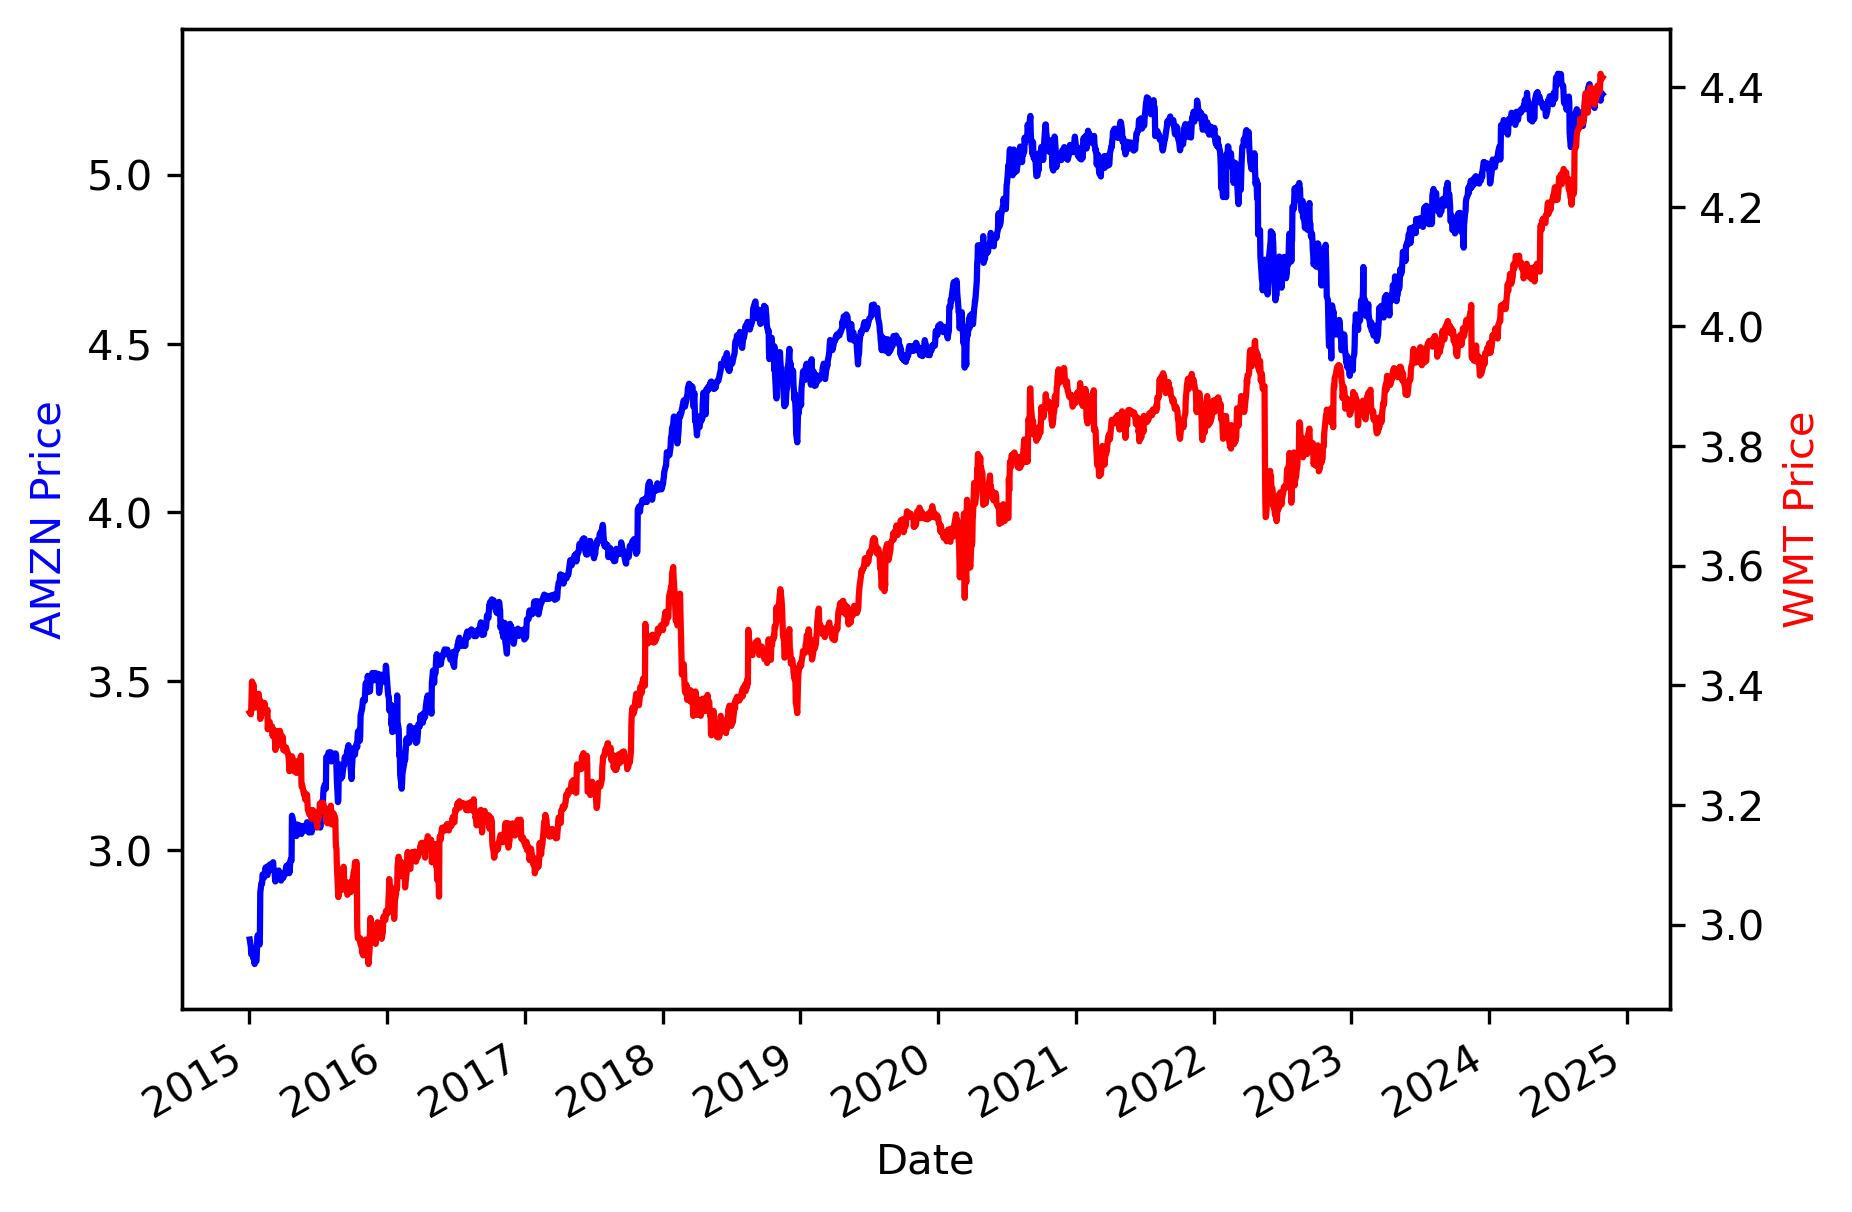

In [29]:
# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# AMZN Price
ols_df['AMZN'].plot(color = 'blue', ax = ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'AMZN Price', 
    color='blue'
    )

# WMT Price
ax2 = ax1.twinx()

ols_df['WMT'].plot(color = 'red', ax = ax2)
ax2.set_ylabel(
    'WMT Price', 
    color='red'
    )

plt.show()

In [30]:
#Model specification
model = sm.OLS(
    ols_df['AMZN'], 
    ols_df[['const', 'WMT', 'SP500']]
    )   
     
#the results of the model
results = model.fit() 
    
#The Parameters
betas = results.params  

#here we check the summary
print(results.summary())    

                            OLS Regression Results                            
Dep. Variable:                   AMZN   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     5816.
Date:                Tue, 15 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:42:59   Log-Likelihood:                -355.18
No. Observations:                2472   AIC:                             716.4
Df Residuals:                    2469   BIC:                             733.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.6913      0.317    -30.549      0.0

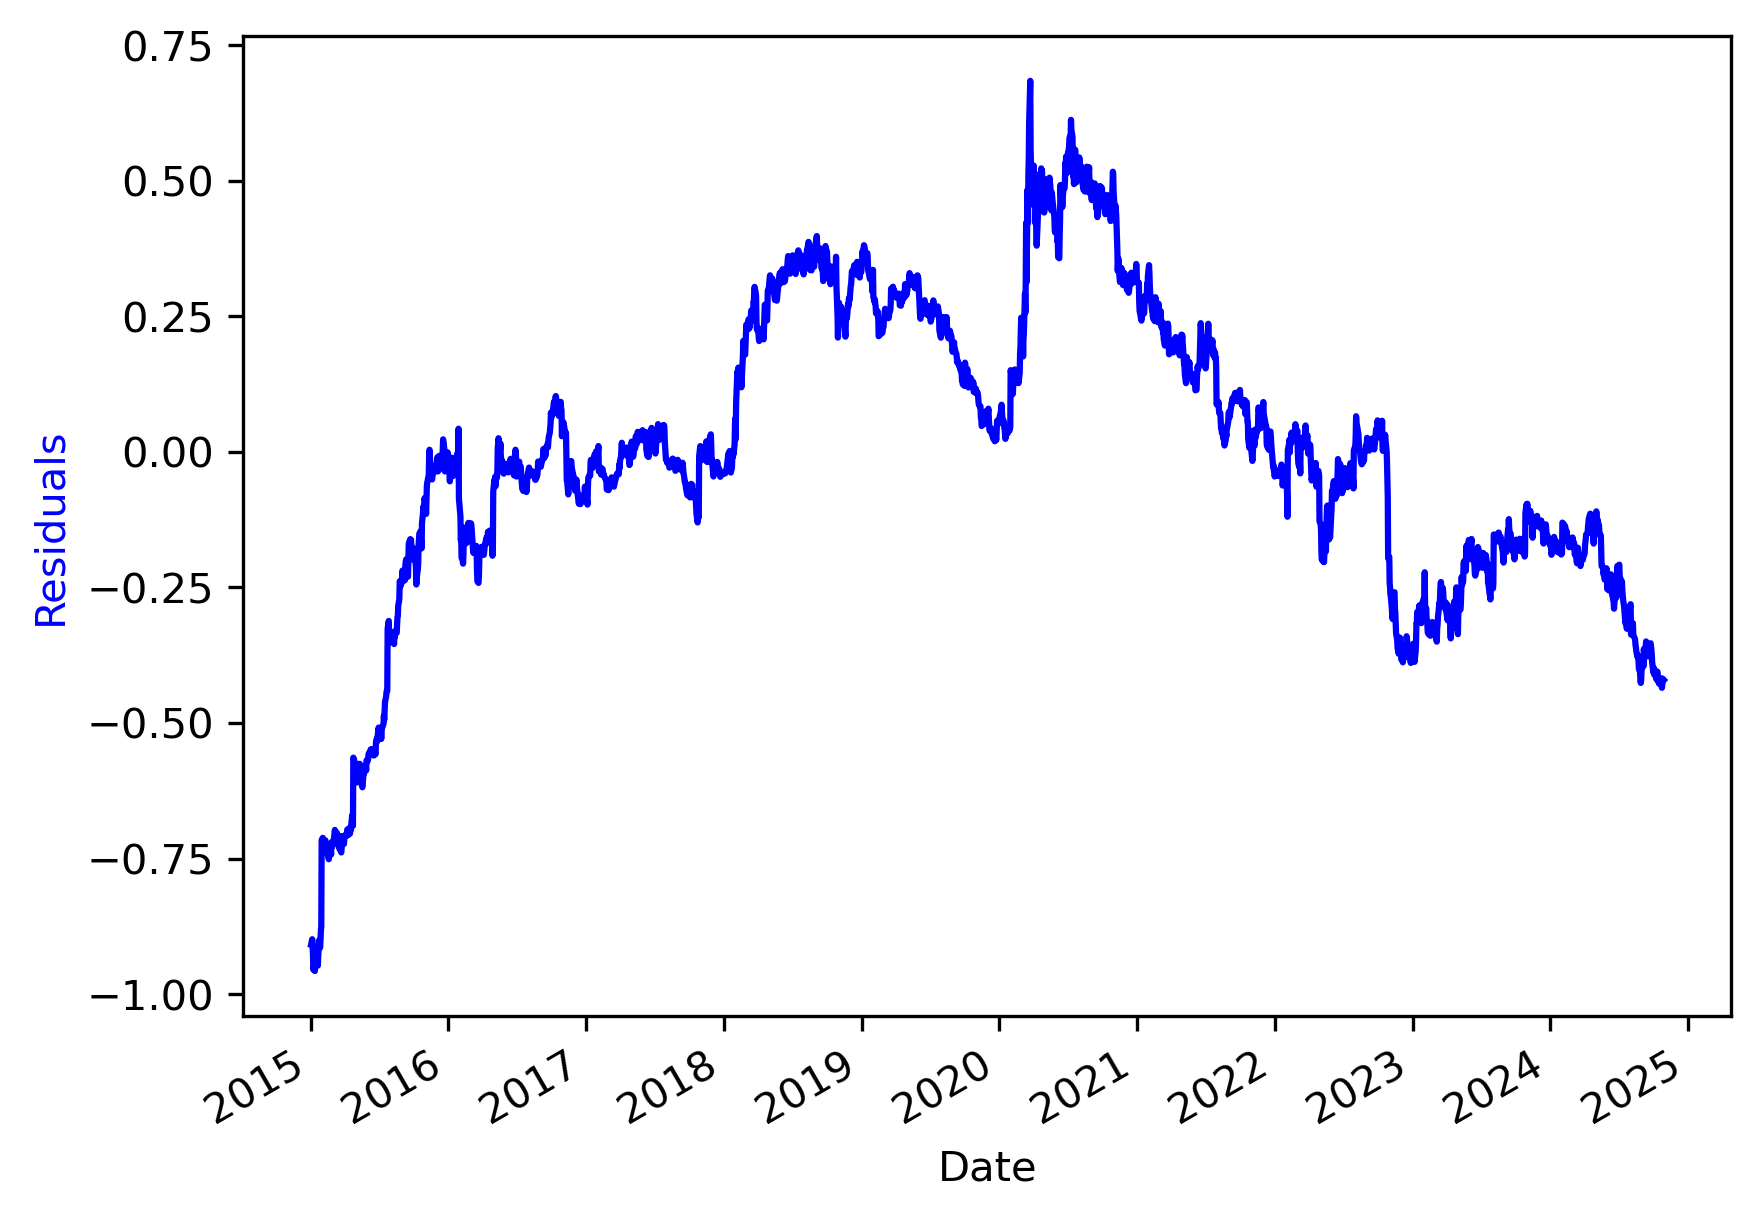

In [31]:
# Check the residuals 

residuals = results.resid

# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# Residuals Rate Plot
residuals.plot(color = 'blue', ax = ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'Residuals', 
    color='blue'
    )

plt.show()

In [32]:
# Let us check some important things

print(f"The Residuals Mean is: {residuals.mean().round(3)}")
print(f"The Residuals Variance is: {residuals.var()}")

The Residuals Mean is: -0.0
The Residuals Variance is: 0.07807325516152155


In [33]:
# Test for Heteroskedasticity (null: homoskedasticity)

bp_test = het_breuschpagan(
    residuals, 
    sm.add_constant(ols_df[['WMT', 'SP500']])
)

labels = ['LM statistic', 'p-value', 'F-statistic', 'F p-value']
print(dict(zip(labels, bp_test)))

{'LM statistic': 956.8289639962387, 'p-value': 1.6874480272812753e-208, 'F-statistic': 779.5854910009147, 'F p-value': 3.644074048526221e-263}


In [35]:
# Omega

Omega = np.diag(residuals**2)

Omega

array([[0.82518688, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.80743989, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.82780523, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.18369314, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.17495778,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.17681809]])

In [36]:
# The weighted least squares formula

display(Math(r"\beta_{gls}=(X^⊤WX)^{-1}(X^⊤WY)"))

# In this case

display(Math(r"\Omega^{-1}=W"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [38]:
# If we want to replicate it we have to create the matrix

# Y Vector
Y_Vector = ols_df["AMZN"].to_numpy()

# X matrix
Information_Matrix = ols_df[['const', 'WMT', 'SP500']].to_numpy()

# Weights

W = np.linalg.inv(Omega)

W.round(4)

array([[1.2118, 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 1.2385, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 1.208 , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.    , ..., 5.4439, 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 5.7157, 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 5.6555]])

In [39]:
# Calculate the Weighted Data

Weighted_X = W.dot(Information_Matrix)
Weighted_Y = W.dot(Y_Vector)

In [40]:
# Calculate the components

Information_Matrix_T = Information_Matrix.transpose()

X_Weighted_Var = Information_Matrix_T.dot(Weighted_X)
X_Y_Weighted_Covar = Information_Matrix_T.dot(Weighted_Y)

X_Weighted_Var_Inv = np.linalg.inv(X_Weighted_Var)

In [41]:
# The betas

betas_gls = X_Weighted_Var_Inv.dot(X_Y_Weighted_Covar)

betas_gls.round(4)

array([-9.7022,  0.3272,  1.6054])

In [44]:
# GLS

gls_model = sm.GLS(
    ols_df['AMZN'], 
    sm.add_constant(ols_df[['WMT', 'SP500']]),
    sigma=Omega
)

#the results of the model
gls_results = gls_model.fit()

#here we check the summary
print(gls_results.summary())    

                            GLS Regression Results                            
Dep. Variable:                   AMZN   R-squared:                       1.000
Model:                            GLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.856e+06
Date:                Tue, 15 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:46:56   Log-Likelihood:                 1632.7
No. Observations:                2472   AIC:                            -3259.
Df Residuals:                    2469   BIC:                            -3242.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.7022      0.014   -706.302      0.0

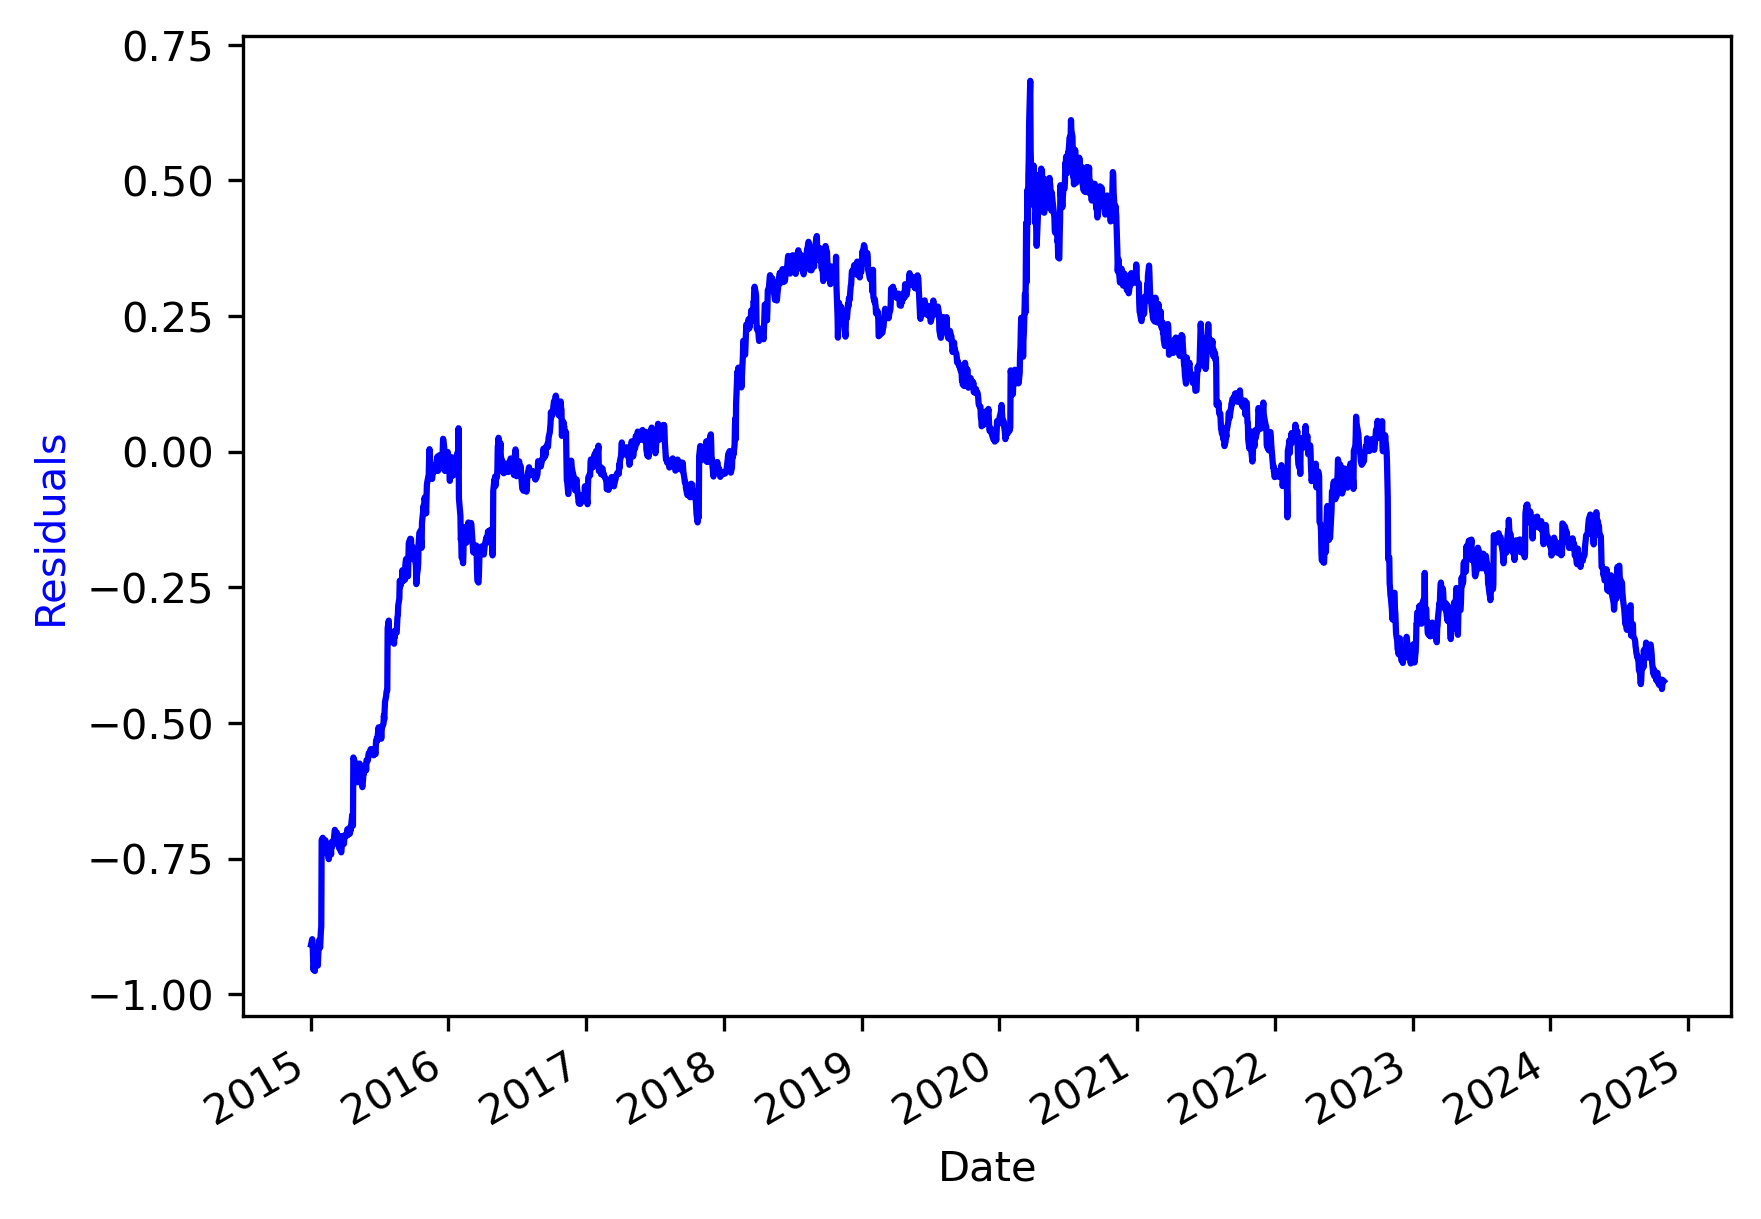

In [45]:
# Check the residuals 

residuals_gls = gls_results.resid

# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# Residuals Rate Plot
residuals_gls.plot(color = 'blue', ax = ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'Residuals', 
    color='blue'
    )

plt.show()

In [46]:
# Calculate the Sums of Squares

# First the Weighted Mean
y_w_mean = np.sum(W.diagonal() * y) / np.sum(W)

# The Fitted Values
y_hat_gls = gls_results.fittedvalues

In [47]:
# Calculate the Total Sum of Squares

SST_wls = np.sum(W.diagonal() * (y - y_w_mean)**2)

SST_wls

7680332.661509378

In [48]:
# Calculate the Residual Sum of Squares

SSR_wls = np.sum(W.diagonal() * (y - y_hat_gls)**2)

SSR_wls

2458.1779182352548

In [49]:
# Calculate the R-Squared

R_Squared_GLS = 1 - (SSR_wls/SST_wls)

R_Squared_GLS

0.999679938613785

In [50]:
# Test for Heteroskedasticity (null: homoskedasticity)

bp_test = het_breuschpagan(
    residuals_gls, 
    sm.add_constant(ols_df[['WMT', 'SP500']])
)

labels = ['LM statistic', 'p-value', 'F-statistic', 'F p-value']
print(dict(zip(labels, bp_test)))

{'LM statistic': 954.8348288520347, 'p-value': 4.573528084257047e-208, 'F-statistic': 776.9382125519917, 'F p-value': 1.8481581198476545e-262}


Why didn’t we eliminate heteroskedasticity?

Even though we applied GLS to correct for heteroskedasticity, it may still persist if the variables in the regression are non-stationary. This is one of the reasons why we use returns instead of prices when modeling financial data — returns tend to be stationary and reduce the presence of structural heteroskedasticity.